In [2]:
import pickle
import numpy as np
from scipy import sparse
from os import listdir

# Read in variant coordinates
coord_file = 'bootstrap/1e4_bootstrap/0.pkl'
coordinates = np.asarray([tuple(map(int, x.decode('UTF-8').split('-'))) for x in pickle.load(open(coord_file, 'rb'))], dtype=int)
coordinates = coordinates[coordinates[:, 0] >= 21, :]

order_indices = np.lexsort((coordinates[:, 1], coordinates[:, 0]))
#print(coordinates.shape, coordinates)
#print(coordinates[order_indices, :])

In [55]:
data_dir = '../split_gen_miss'

subcoordinates = []
submatrices = []
for chrom in range(21, 23):

    # pull coordinates for chromosome
    chrom_coords = np.load('%s/chr.%d.gen.coordinates.npy' %(data_dir, chrom))
    to_find = coordinates[order_indices, :]
    to_find = to_find[to_find[:, 0]==chrom, :]
    #print(chrom_coords.shape, to_find.shape)

    # find indices of the variants we're looking for on this chromosome
    pull_indices = np.searchsorted(chrom_coords[:, 1], to_find[:, 1])
    #print(np.hstack((to_find, chrom_coords[pull_indices, :])))

    # load genotype data from .npz
    gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s' % chrom) in f and 'gen.npz' in f])
    whole_chrom = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file)) for gen_file in gen_files])
    print(chrom, whole_chrom.shape)
    
    subcoordinates.append(chrom_coords[pull_indices, :])
    submatrices.append(whole_chrom[:, pull_indices])

ordered_full_coords = np.vstack(subcoordinates)
ordered_full_matrix = sparse.hstack(submatrices)
print(ordered_full_matrix.shape)

reverse_order_indices = np.argsort(order_indices)
random_full_coords = ordered_full_coords[reverse_order_indices, :]
random_full_matrix = ordered_full_matrix[:, reverse_order_indices]
#print(ordered_full_matrix.shape)
#print(np.hstack((coordinates, random_full_coords)))

21 (4610, 1153632)
22 (4610, 1096535)
(4610, 741)


NameError: name 'full_matrix' is not defined

In [59]:
sparse.save_npz(coord_file[:-3] + 'iHART', random_full_matrix)

In [60]:
print(random_full_matrix.dtype)

int8


In [61]:
X = random_full_matrix.copy()

In [62]:
X[X<0] = 0

In [63]:
print(X.nnz)

731444


In [64]:
print(np.min(X))

0


In [7]:
# look at matrices
ihart = sparse.load_npz('bootstrap/1e4_bootstrap/0.iHART.npz').A
psp = sparse.load_npz('bootstrap/1e4_bootstrap/0.PSP.npz').A

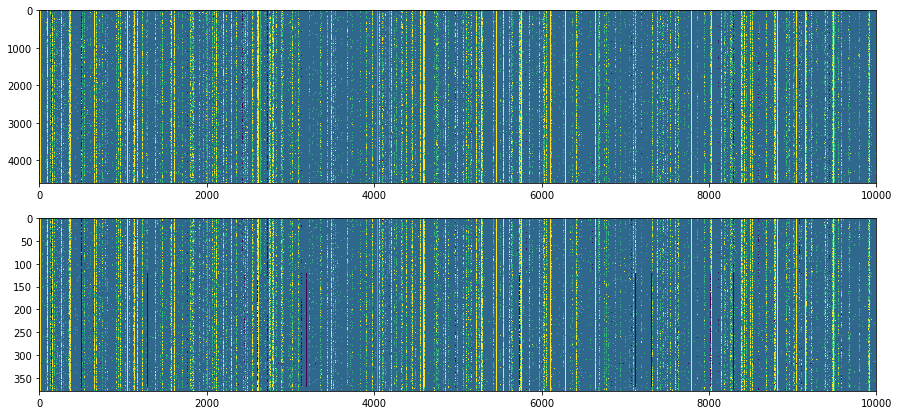

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.subplot(2, 1, 1)
plt.imshow(ihart, aspect='auto', vmax=2, vmin=-1)
plt.subplot(2, 1, 2)
plt.imshow(psp, aspect='auto', vmax=2, vmin=-1)
plt.show()

In [59]:
from scipy.stats import chi2_contingency

def calculate_pvalue(dc):
    # get rid of 0 rows/columns
    dc = dc[np.any(dc>0, axis=1), :]

    # calculate pvalue
    if dc.shape[0] > 1 and dc.shape[1] > 1:
        return chi2_contingency(dc, correction=True)[1]
    return 1

m, n = ihart.shape

pvalues = np.ones((n,))
missing_pvalues = np.ones((n,))
gen_pvalues = np.ones((n,))
for i in range(n):
    dc = np.asarray([[np.sum(ihart[:, i]<0), np.sum(psp[:, i]<0)],
                     [np.sum(ihart[:, i]==0), np.sum(psp[:, i]==0)],
                     [np.sum(ihart[:, i]==1), np.sum(psp[:, i]==1)],
                     [np.sum(ihart[:, i]==2), np.sum(psp[:, i]==2)],
                    ])
    pvalues[i] = calculate_pvalue(dc)
        
    dc = np.asarray([[np.sum(ihart[:, i]<0), np.sum(psp[:, i]<0)],
                     [np.sum(ihart[:, i]>=0), np.sum(psp[:, i]>=0)]
                    ])
    missing_pvalues[i] = calculate_pvalue(dc)
        
    dc = np.asarray([[np.sum(ihart[:, i]==0), np.sum(psp[:, i]==0)],
                     [np.sum(ihart[:, i]==1), np.sum(psp[:, i]==1)],
                     [np.sum(ihart[:, i]==2), np.sum(psp[:, i]==2)],
                    ])
    gen_pvalues[i] = calculate_pvalue(dc)


In [60]:
zero_pvalue = np.where(pvalues==0)[0]
i = zero_pvalue[0]
dc = np.asarray([[np.sum(ihart[:, i]<0), np.sum(psp[:, i]<0)],
                     [np.sum(ihart[:, i]==0), np.sum(psp[:, i]==0)],
                     [np.sum(ihart[:, i]==1), np.sum(psp[:, i]==1)],
                     [np.sum(ihart[:, i]==2), np.sum(psp[:, i]==2)],
                    ])

print(dc)

dc = dc[np.any(dc>0, axis=1), :]
print(dc)

[[   0  251]
 [1184   39]
 [3425   88]
 [   1    1]]
[[   0  251]
 [1184   39]
 [3425   88]
 [   1    1]]


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


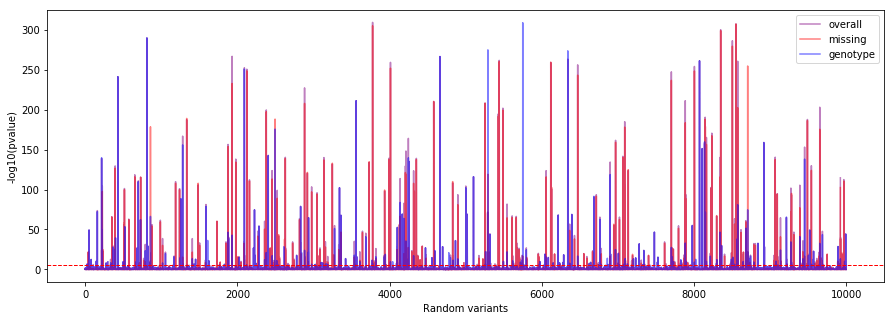

9458
9456


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


In [65]:
plt.figure(figsize=(15, 5))

plt.plot(-np.log10(pvalues), alpha=0.5, color='purple', label='overall')
plt.plot(-np.log10(missing_pvalues), alpha=0.5, color='red', label='missing')
plt.plot(-np.log10(gen_pvalues), alpha=0.5, color='blue', label='genotype')

plt.legend()
plt.axhline(y=-np.log10(0.05/n), linewidth=1, linestyle='--', color='r')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Random variants')
plt.show()

print(np.sum(-np.log10(pvalues) < -np.log10(0.05/n)))
print(np.sum((-np.log10(pvalues) < -np.log10(0.05/n)) & (-np.log10(missing_pvalues) < -np.log10(0.05/n)) & (-np.log10(gen_pvalues) < -np.log10(0.05/n))))

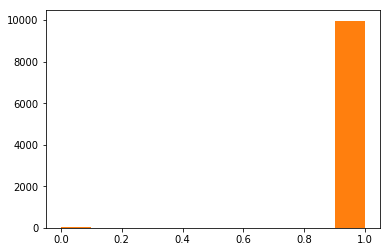

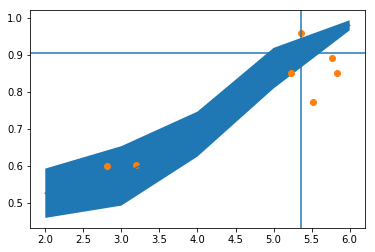

In [91]:
x = np.log10([100, 1000, 10000, 100000, 1000000])
m = np.asarray([0.526, 0.573, 0.686, 0.864, 0.980])
s = np.asarray([0.034, 0.041, 0.031, 0.028, 0.007])
plt.plot(x, m)
plt.fill_between(x, m-1.96*s, m+1.96*s)
plt.scatter(np.log10([1564, 647, 577900, 325003, 684487, 232193, 168953]), 
            [0.602, 0.6, 0.891, 0.774, 0.852, 0.960, 0.85])
plt.axhline(new_m)
plt.show()

In [95]:
# calculate mean on log scale
new_m = m[3] + (m[4]-m[3])*(np.log10(232193)-5)
new_s = s[3] + (s[4]-s[3])*(np.log10(232193)-5)
print(new_m, new_s)

print((0.960-new_m)/new_s)

0.9064384982423599 0.020317168421641742
2.636268039230636


In [88]:
import gzip

simple_repeat_vs = [('17', '11206720'), ('10', '49883667'), ('22', '27486124'), ('3', '30550980'), ('7', '137369693'), 
                    ('8', '26074016'), ('14', '37565015'), ('X', '3127935'), ('X', '55147362'), ('X', '143750718')]
simple_repeat_sign = ['+', '-', '+', '+', '-', 
                      '-', '+', '+', '-', '-']

for (chrom, pos), sign in zip(simple_repeat_vs, simple_repeat_sign):
    try:
        with gzip.open('../split_gen_miss_psp/chr.%s.gen.variants.txt.gz' % chrom, 'rt') as f:
            for line in f:
                pieces = line.strip().split('\t', maxsplit=2)
                if pos == pieces[1]:
                    pieces = line.strip().split('\t')
                    print('PSP\t', sign, chrom, pos, pieces[3], pieces[4])
    except:
        pass
    
    try:
        with gzip.open('../split_gen_miss/chr.%s.gen.variants.txt.gz' % chrom, 'rt') as f:
            for line in f:
                pieces = line.strip().split('\t', maxsplit=2)
                if pos == pieces[1]:
                    pieces = line.strip().split('\t')
                    print('iHART\t', sign, chrom, pos, pieces[3], pieces[4])
    except:
        pass


PSP + 17 11206720 TTG T
iHART + 17 11206720 TTG T
PSP - 10 49883667 T A
iHART - 10 49883667 T A
PSP + 22 27486124 G A
iHART + 22 27486124 G A
PSP + 3 30550980 TATATG T
iHART + 3 30550980 TATATG T
PSP - 7 137369693 G A
iHART - 7 137369693 G A
PSP - 8 26074016 T C
iHART - 8 26074016 T C
PSP + 14 37565015 A G
iHART + 14 37565015 A G
PSP + X 3127935 C CTCTA
PSP - X 55147362 T G
PSP - X 143750718 CAT C
